In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import matplotlib
#important for text to be detected when importing saved figures into illustrator
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42


In [ ]:
# paths for raw data
# the inscopix data will be saved in the tracefolderpath as trace csv
# the behavior data, in this case manually annotated data, will be 
rootpath = r"...\Data\Figure 2 and S3, S4"
resultfolderpath = os.path.join(rootpath,"data")
figurepath = os.path.join(rootpath,"figures")
summaryfigurepath = os.path.join(rootpath,"summary_figures","Final")
metainfopath = os.path.join(rootpath,"meta")
for x in [figurepath,]:
    if not os.path.exists(x):
        os.mkdir(x)

In [4]:
# read metainfo
metainfo = pd.read_csv(os.path.join(metainfopath,"metainfo.csv"),index_col = False)
brainatlasdf = pd.read_csv(os.path.join(metainfopath,"atlas_info_KimRef_FPbasedLabel_v2.9_brain_with_ancenstor.csv"),index_col = False)
brainatlasdf = brainatlasdf.rename(columns = {'name':'Name'})


# Create heatmap arrays

In [ ]:
# load the data
total_merge_df = pd.read_csv(os.path.join(resultfolderpath,"tdTomato_summary.csv"),index_col = False)

level_4_order = ['CTXpl', 'CTXsp', 'STR', 'PAL', 
       'TH', 'HY', 'MBsen', 'MBmot','MBsta', 'P',
       ]

       
total_merge_df = total_merge_df[total_merge_df.ancestor_level_4_acronym.isin(level_4_order)]


In [6]:
# pivot the data frame to make a heatmap
Appetitive_individual_heatmap = total_merge_df.loc[total_merge_df.Stim == 'Appetitive',\
                                                    ['Name','acronym','depth','ID','density','ancestor_level_4_acronym']]\
.set_index(['Name','acronym','depth','ancestor_level_4_acronym']).pivot(columns = 'ID')

Post_ejaculatory_individual_heatmap = total_merge_df.loc[total_merge_df.Stim == 'Post_ejaculatory',\
                                                    ['Name','acronym','depth','ID','density','ancestor_level_4_acronym']]\
.set_index(['Name','acronym','depth','ancestor_level_4_acronym']).pivot(columns = 'ID')

Consummatory_individual_heatmap = total_merge_df.loc[total_merge_df.Stim == 'Consummatory',\
                                                    ['Name','acronym','depth','ID','density','ancestor_level_4_acronym']]\
.set_index(['Name','acronym','depth','ancestor_level_4_acronym']).pivot(columns = 'ID')

merge_individual_heatmap = pd.concat([Appetitive_individual_heatmap,Consummatory_individual_heatmap,Post_ejaculatory_individual_heatmap],axis = 1)

In [7]:
# Subset the heatmap df and sort it based on a specific Level 4 
'''level_4_order = ['CTXpl', 'CTXsp', 'STR', 'PAL', 'VERM','HEM', 'Int', 'DN',
       'TH', 'HY', 'PR', 'MBsen', 'MBmot','MBsta', 'RI', 'DA11', 'P',
       'MY']
level_4_order = ['CTXpl', 'CTXsp', 'STR', 'PAL', 
       'TH', 'HY', 'PR', 'MBsen', 'MBmot','MBsta', 'RI', 'DA11', 'P',
       'MY','VERM','HEM', 'Int', 'DN',]'''

submerge_individual_heatmap = merge_individual_heatmap.xs(6, level='depth')
# Create a mapping from 'level1' values to the order
mapping = {value: i for i, value in enumerate(level_4_order)}



# Create a new column '_sort' based on the 'level1' values mapped to the order
submerge_individual_heatmap['_sort'] = submerge_individual_heatmap.index.get_level_values('ancestor_level_4_acronym').map(mapping)

# Sort the DataFrame by the '_sort' column
submerge_individual_heatmap = submerge_individual_heatmap.sort_values('_sort')

# Drop the '_sort' column
submerge_individual_heatmap = submerge_individual_heatmap.drop(columns=['_sort'])


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_27316\3821757128.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submerge_individual_heatmap['_sort'] = submerge_individual_heatmap.index.get_level_values('ancestor_level_4_acronym').map(mapping)


In [8]:
# calculate variables to plot the heatmatp
level_6_acronyms = submerge_individual_heatmap.index.get_level_values('acronym')

level_4_acronyms,__ = np.unique(submerge_individual_heatmap.index.get_level_values('ancestor_level_4_acronym'),return_counts = True)
level_4_acronyms = [f for f in level_4_acronyms if f in total_merge_df[total_merge_df.depth == 4].acronym.unique()]

counts = [submerge_individual_heatmap.xs(f,level='ancestor_level_4_acronym').shape[0] for f in level_4_order if f in level_4_acronyms]

borders = [0] + list(np.cumsum(counts))

x = np.array(borders)
yticks = (x[1:] + x[:-1]) / 2
ytick_labels = [f for f in level_4_order if f in level_4_acronyms]

n_Appetitive = len(total_merge_df[total_merge_df.Stim== 'Appetitive'].ID.unique())
n_Post_ejaculatory = len(total_merge_df[total_merge_df.Stim== 'Post_ejaculatory'].ID.unique())
n_Consummatory = len(total_merge_df[total_merge_df.Stim== 'Consummatory'].ID.unique())

xticks = [n_Appetitive/2,n_Appetitive + n_Consummatory/2,n_Appetitive + n_Consummatory + n_Post_ejaculatory/2]
xticklabels = ['Appetitive','Consummatory','Post_ejaculatory',]

# Statistical analysis

In [11]:
# load data
total_merge_df = pd.read_csv(os.path.join(resultfolderpath,"tdTomato_summary.csv"),index_col = False)

In [12]:
# create a stats dataframe
stats_df = brainatlasdf.copy()

In [13]:
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
from scipy.stats import f_oneway

variable = 'density'
group_1 = 'Post_ejaculatory'
group_2 = 'Appetitive'
group_3 = 'Consummatory'

In [14]:
# run one way Anova for each brain region
pvalues = []
acronyms = []
fvalues = []
average_densities = []
for acronym in total_merge_df.acronym.unique():
    a = total_merge_df[(total_merge_df.acronym == acronym)&(total_merge_df.Stim == group_1)].density.values
    b = total_merge_df[(total_merge_df.acronym == acronym)&(total_merge_df.Stim == group_2)].density.values
    c = total_merge_df[(total_merge_df.acronym == acronym)&(total_merge_df.Stim == group_3)].density.values
    average_density = np.nanmean(a)
    # run ttest
    F,p = f_oneway(a,b,c)
    if not np.isnan(p):
        stats_df.loc[stats_df.acronym == acronym,'ANOVA_pvalue'] = p
        stats_df.loc[stats_df.acronym == acronym,'ANOVA_Fvalue'] = F
        stats_df.loc[stats_df.acronym == acronym,'average_density'] = average_density
        df1 = 3 - 1
        df2 = len(a) + len(b) + len(c) - df1
        stats_df.loc[stats_df.acronym == acronym,'ANOVA_Fstatistic'] = f'F({df1},{df2})'


c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [15]:
# run a Benjamini/Hochberg FDR correction for level 4 and 6
#depth = 4
for depth in [4,6]:
    if depth == 4:
        tacronyms = ytick_labels
    elif depth == 6:
        tacronyms = level_6_acronyms

    temp_pvalues = stats_df.loc[stats_df.acronym.isin(tacronyms),'ANOVA_pvalue']
    (sign,qvalues,) = multitest.fdrcorrection(temp_pvalues,alpha=0.1, method='indep',)       
    # add corrected q values and significance to stats_df
    stats_df.loc[stats_df.acronym.isin(tacronyms),'ANOVA_qvalue_fdr_corrected'] = qvalues
    stats_df.loc[stats_df.acronym.isin(tacronyms),'ANOVA_sig_fdr_corrected'] = sign 


In [16]:
# Tukey HSDs for areas of interest
from scipy.stats import tukey_hsd
for aidx,acronym in enumerate(total_merge_df.acronym.unique()):
    a = total_merge_df[(total_merge_df.acronym == acronym)&(total_merge_df.Stim == group_1)].density.values
    b = total_merge_df[(total_merge_df.acronym == acronym)&(total_merge_df.Stim == group_2)].density.values
    c = total_merge_df[(total_merge_df.acronym == acronym)&(total_merge_df.Stim == group_3)].density.values
    
    # run tukey_HSD
    res = tukey_hsd(a,b,c)
    #print(acronym)
    #print(res)

    avbp = res.pvalue[0,1]
    avcp = res.pvalue[0,2]
    cvbp = res.pvalue[1,2]

    # add pvalues
    stats_df.loc[stats_df.acronym == acronym,
    [group_1 + 'vs' +group_2,
    group_1 + 'vs' +group_3,
    group_2 + 'vs' +group_3]] = avbp,avcp,cvbp

    # add significance
    stats_df.loc[stats_df.acronym == acronym,
    [group_1 + 'vs' +group_2 + '_sign',
    group_1 + 'vs' +group_3 + '_sign',
    group_2 + 'vs' +group_3 + '_sign']] = avbp <0.05,avcp <0.05,cvbp <0.05

    # what type of ttest result
    a,b,c = stats_df.loc[stats_df.acronym == acronym,
        [group_1 + 'vs' +group_2 + '_sign',
        group_1 + 'vs' +group_3 + '_sign',
        group_2 + 'vs' +group_3 + '_sign']].values[0]
    stats_df.loc[stats_df.acronym == acronym, 'TukeyHSD_result_type']= int(str(int(a)) + str(int(b)) + str(int(c)),2)  

c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\scipy\stats\_hypotests.py:2000: RuntimeWarning: invalid value encountered in divide
  t_stat = np.abs(mean_differences) / stand_err


In [17]:
stats_df.to_csv(os.path.join(resultfolderpath,'stats_df.csv'),index = False)

# Figure 2C

In [18]:
# load data
total_merge_df = pd.read_csv(os.path.join(resultfolderpath,"tdTomato_summary.csv"),index_col = False)
stats_df = pd.read_csv(os.path.join(resultfolderpath,'stats_df.csv'),index_col = False)

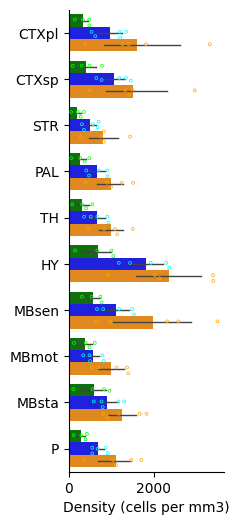

In [19]:
fig,axs = plt.subplots(1,1,figsize = (2,6))
sns.barplot(data = total_merge_df[total_merge_df.acronym.isin(ytick_labels)],order = ytick_labels,
            y = 'acronym',x = 'density',hue = 'Stim',ax = axs,errwidth = 1,palette = ['green','blue','darkorange'],\
              hue_order = xticklabels)
sns.swarmplot(data = total_merge_df[total_merge_df.acronym.isin(ytick_labels)],order = ytick_labels,
            y = 'acronym',x = 'density',hue = 'Stim',dodge = True,ax = axs,hue_order = xticklabels,
              facecolors='none',palette = ['lime','cyan','orange'], marker="$\circ$", ec="face",s = 4)
#plt.xticks(rotation = 45)
sns.despine()
axs.get_legend().remove()
axs.set_xlabel('Density (cells per mm3)')
axs.set_ylabel('')
#axs.set_xticklabels(np.linspace(0,0.4,3))
fig.savefig(os.path.join(figurepath,'Figure2C.png'),dpi = 216,bbox_inches ='tight')
fig.savefig(os.path.join(figurepath,'Figure2C.pdf'),bbox_inches ='tight')

# Figure 2D

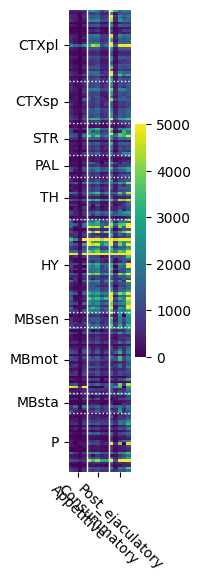

In [20]:

fig,axs = plt.subplots(1,1,figsize = (1,6))
#sns.heatmap(data = submerge_individual_heatmap,ax = axs,vmin = 0,vmax = 10000,cmap = 'viridis')
sns.heatmap(data = submerge_individual_heatmap,ax = axs,vmin = 0,vmax = 5000,cmap = 'viridis')
#sns.heatmap(data = submerge_individual_heatmap,ax = axs,vmin = -2,vmax = 5,cmap = 'viridis')
[axs.axhline(border,color = 'white',lw = 1,ls = ':') for border in borders[1:-1]]
axs.set_yticks(yticks)
axs.set_yticklabels(ytick_labels,rotation = 0)
axs.axvline(n_Appetitive,color = 'white',lw = 1)
axs.axvline(n_Appetitive + n_Consummatory,color = 'white',lw = 1)

axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels,rotation = -45)
axs.set_xlabel('')
axs.set_ylabel('')
fig.savefig(os.path.join(figurepath,'Figure2D.png'),dpi = 216,bbox_inches ='tight')
fig.savefig(os.path.join(figurepath,'Figure2D.pdf'),bbox_inches ='tight')

# Figure 2I

In [21]:
# load the data
total_merge_df = pd.read_csv(os.path.join(resultfolderpath,"tdTomato_summary.csv"),index_col = False)

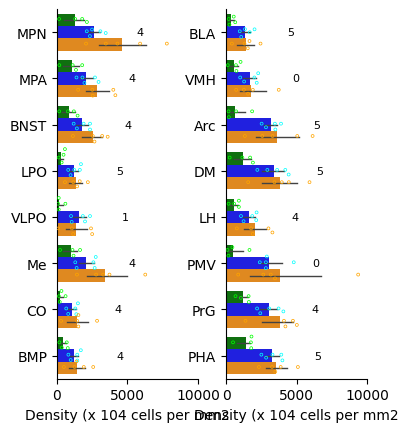

In [22]:
# Regions in the figure
#regions = ['MPN','MPA','BNST','LPO','VLPO'] \
#+ ['MeA','CoA','BMP','BLA','BLP','VMH','Arc','DM','LH','SCh',] \
#+ ['PMV','AO','GENv','PS']
regions = ['MPN','MPA','BNST','LPO','VLPO'] \
+ ['Me','CO','BMP','BLA','VMH','Arc','DM','LH',] \
+ ['PMV','PrG','PHA']



fig,axss = plt.subplots(1,2,figsize = (2*2,len(regions)/10 * 3,),sharex = True)

for fidx,axs in enumerate(axss):
  tregions = regions[fidx*len(regions)//2:(fidx+1)*len(regions)//2]
  temp_df = total_merge_df[total_merge_df.acronym.isin(tregions)]

  sns.barplot(data = temp_df,order = tregions,
              y = 'acronym',x = 'density',hue = 'Stim',ax = axs,errwidth =1,palette = ['green','blue','darkorange'],\
                hue_order = xticklabels)
  sns.swarmplot(data = temp_df,order = tregions,
          y = 'acronym',x = 'density',hue = 'Stim',dodge = True,ax = axs,
            facecolors='none',palette = ['lime','cyan','orange'],\
                hue_order = xticklabels, marker="$\circ$", ec="face",s = 4)
  #plt.xticks(rotation = 45)
  # Adding annotations to each bar
  container =  axs.containers[1]
  for bidx,bar in enumerate(container):
      tacronym = tregions[bidx]
      ttest_type = stats_df.loc[stats_df.acronym == tacronym,'TukeyHSD_result_type'].values.astype('int')[0]
      axs.text(
          bar.get_width() + 3000,  # Adjust to position slightly above the bar
          bar.get_y() + bar.get_height() / 2,
          f'{int(ttest_type):,}',  # Format to display integer values with commas
          ha='left', va='center', fontsize=8, color='black'
      )
  sns.despine()
  axs.set_xlim(0,10000)
  axs.get_legend().remove()
  axs.set_xlabel('Density (x 104 cells per mm2')
  axs.set_ylabel('')
  #axs.set_xticklabels(np.linspace(0,1,2))

fig.savefig(os.path.join(figurepath,'Figure2I.png'),dpi = 216,bbox_inches ='tight')
fig.savefig(os.path.join(figurepath,'Figure2I.pdf'),bbox_inches ='tight')

# Figure S2

c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\stuberadmin\ana

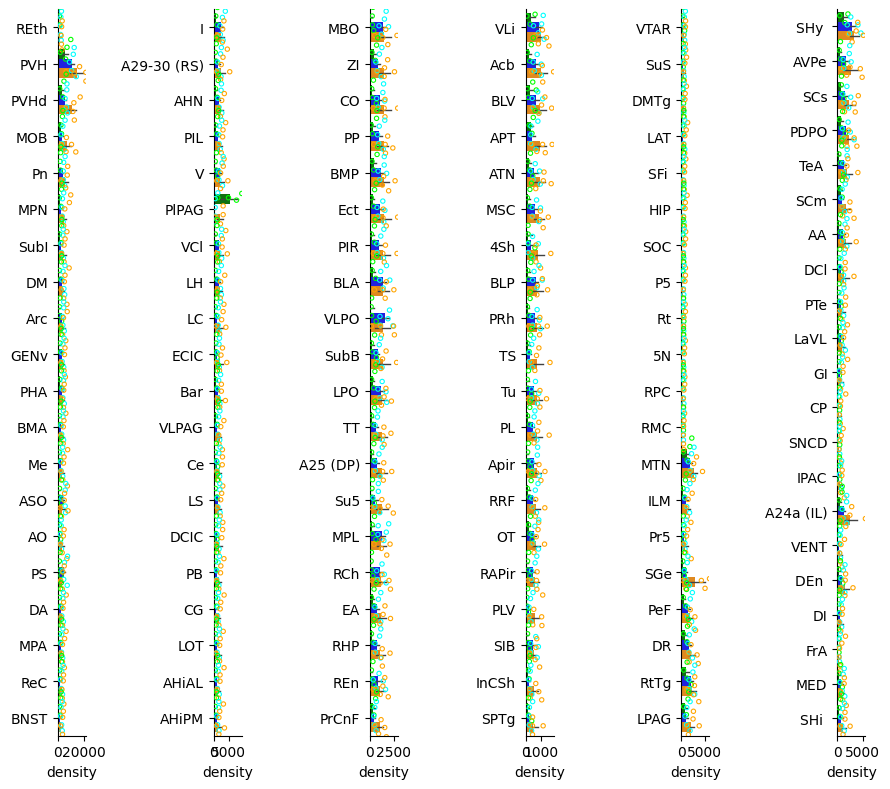

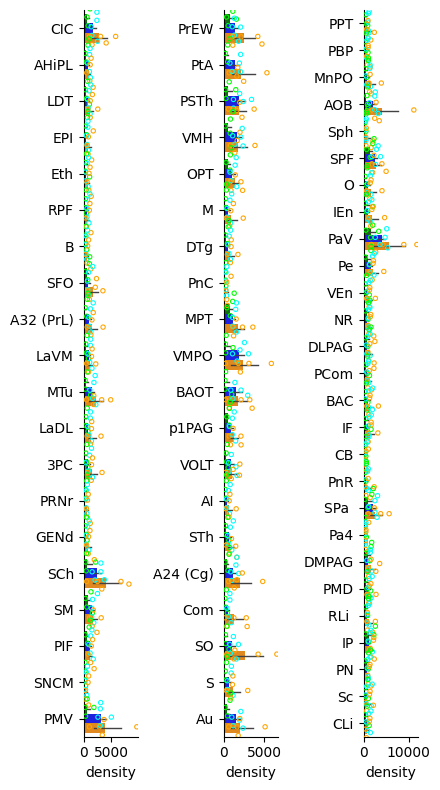

In [23]:
from matplotlib.ticker import FormatStrFormatter
stats_df = stats_df[stats_df.depth == 6]
for tidx,tempstats_df in enumerate([stats_df[stats_df.ANOVA_qvalue_fdr_corrected < 0.1],stats_df[stats_df.ANOVA_qvalue_fdr_corrected > 0.1]]):
    bins = 20
    height = bins/2.5
    columns = tempstats_df.shape[0]//bins
    fig,axs = plt.subplots(1,columns,figsize = (1.5*columns,height),sharex = False,)
    
    for idx in range(columns):
        if idx == columns-1:
            regions = tempstats_df.sort_values(by = ['ANOVA_qvalue_fdr_corrected','average_density'],ascending = [True,False]).acronym.values[bins*idx:]
        else:
            regions = tempstats_df.sort_values(by = ['ANOVA_qvalue_fdr_corrected','average_density'],ascending = [True,False]).acronym.values[bins*idx:bins*(idx+1)]
        temp_df = total_merge_df[total_merge_df.acronym.isin(regions)]

        sns.barplot(data = temp_df,order = regions,
                    y = 'acronym',x = 'density',hue = 'Stim',ax = axs[idx],errwidth =1,palette = ['green','blue','darkorange'],\
                    hue_order = xticklabels)
        sns.swarmplot(data = temp_df,order = regions,
                y = 'acronym',x = 'density',hue = 'Stim',dodge = True,ax = axs[idx],
                facecolors='none',palette = ['lime','cyan','orange'],\
                    hue_order = xticklabels, marker="$\circ$", ec="face",s = 6)
        #plt.xticks(rotation = 45)
        sns.despine()
        axs[idx].get_legend().remove()
        axs[idx].set_ylabel('')
        #axs[idx].set_xlabel('Density (x 106 cells per mm2')
        plt.tight_layout()
        #axs[idx].xaxis.set_major_formatter(lambda x, pos: str(x-5))

    fig.savefig(os.path.join(figurepath,'FigureS2_' + str(tidx+1) + '_sorted_by_delta_density_sub_regions_density_subset_revision.png'),dpi = 216,bbox_inches ='tight')
    fig.savefig(os.path.join(figurepath,'FigureS2_' + str(tidx+1) + '_sorted_by_delta_density_sub_regions_density_subset_revision.pdf'),bbox_inches ='tight')